In [1]:
#!pip3 install gmpy2
#!pip3 install StableSwapPy

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from stableswappy import *

In [2]:
def get_reserves_after_swap(reserve_a: float, reserve_b: float, 
                          delta_a: float, delta_b: float) -> tuple[float, float]:
    """
    Calculate new reserve amounts after a swap is executed.
    
    Args:
        reserve_a: Initial reserve amount of token A
        reserve_b: Initial reserve amount of token B
        delta_a: Change in token A amount (positive for adding, negative for removing)
        delta_b: Change in token B amount (positive for adding, negative for removing)
    
    Returns:
        tuple containing (reserve_a_after, reserve_b_after)
    """
    # Validate inputs
    if reserve_a < 0 or reserve_b < 0:
        raise ValueError("Reserves cannot be negative")
    if reserve_a + delta_a < 0 or reserve_b + delta_b < 0:
        raise ValueError("Swap would result in negative reserves")
    
    # Calculate new reserves
    reserve_a_after = reserve_a + delta_a
    reserve_b_after = reserve_b + delta_b
    
    return (reserve_a_after, reserve_b_after)

def compute_reserve_weight(reserve_a: float, reserve_b: float) -> tuple[float, float]:
    """
    Compute the weights of reserves based on their relative proportions.
    
    Args:
        reserve_a: Reserve amount of token A
        reserve_b: Reserve amount of token B
    
    Returns:
        tuple containing (weight_a, weight_b) where weights sum to 1
    """
    # Validate inputs
    if reserve_a < 0 or reserve_b < 0:
        raise ValueError("Reserves cannot be negative")
    
    total = reserve_a + reserve_b
    
    # Handle edge case where total reserves are 0
    if total == 0:
        return (0.5, 0.5)  # Default to equal weights
    
    # Calculate weights
    weight_a = reserve_a / total
    weight_b = reserve_b / total
    
    return (weight_a, weight_b)

def check_is_balance_improved(old_reserves: tuple[float, float], 
                            new_reserves: tuple[float, float]) -> bool:
    """
    Check if the balance between reserves has improved (moved closer to 50/50).
    
    Args:
        old_reserves: Tuple of (reserve_a, reserve_b) before swap
        new_reserves: Tuple of (reserve_a, reserve_b) after swap
    
    Returns:
        bool indicating if balance has improved
    """
    # Get old and new weights
    old_weight_a, old_weight_b = compute_reserve_weight(old_reserves[0], old_reserves[1])
    new_weight_a, new_weight_b = compute_reserve_weight(new_reserves[0], new_reserves[1])
    
    # Calculate deviation from perfect balance (0.5)
    old_deviation = abs(old_weight_a - 0.5)
    new_deviation = abs(new_weight_a - 0.5)
    
    # Balance improved if new deviation is smaller than old deviation
    return new_deviation < old_deviation

def is_same_quadrant(old_reserves: tuple[float, float], 
                    new_reserves: tuple[float, float]) -> bool:
    """
    Check if weights remain in the same quadrant (both > 0.5 or both < 0.5) before and after swap.
    
    Args:
        old_reserves: Tuple of (reserve_a, reserve_b) before swap
        new_reserves: Tuple of (reserve_a, reserve_b) after swap
    
    Returns:
        bool indicating if weights stayed in same quadrant
    """
    old_weight_a, old_weight_b = compute_reserve_weight(old_reserves[0], old_reserves[1])
    new_weight_a, new_weight_b = compute_reserve_weight(new_reserves[0], new_reserves[1])
    
    # Check if both weights were originally above or below 0.5
    old_quadrant = (old_weight_a > 0.5 and old_weight_b < 0.5) or \
                  (old_weight_a < 0.5 and old_weight_b > 0.5)
    new_quadrant = (new_weight_a > 0.5 and new_weight_b < 0.5) or \
                  (new_weight_a < 0.5 and new_weight_b > 0.5)
    
    # If both weights are exactly 0.5, consider it same quadrant
    if old_weight_a == 0.5 and new_weight_a == 0.5:
        return True
        
    # Return True if they're in the same quadrant configuration
    return old_quadrant == new_quadrant

def compute_delta_weight(old_reserves: tuple[float, float], 
                        new_reserves: tuple[float, float]) -> tuple[float, float]:
    """
    Compute the delta weights of reserves A and B based on quadrant status.
    
    If same quadrant: |weight - new_weight| for each reserve
    If different quadrant: |new_weight - 0.5| for each reserve
    
    Args:
        old_reserves: Tuple of (reserve_a, reserve_b) before swap
        new_reserves: Tuple of (reserve_a, reserve_b) after swap
    
    Returns:
        tuple of (delta_weight_a, delta_weight_b)
    """
    old_weight_a, old_weight_b = compute_reserve_weight(old_reserves[0], old_reserves[1])
    new_weight_a, new_weight_b = compute_reserve_weight(new_reserves[0], new_reserves[1])
    
    if is_same_quadrant(old_reserves, new_reserves):
        delta_a = abs(old_weight_a - new_weight_a)
        delta_b = abs(old_weight_b - new_weight_b)
    else:
        delta_a = abs(new_weight_a - 0.5)
        delta_b = abs(new_weight_b - 0.5)
    
    return (delta_a, delta_b)

def compute_portion(
    old_reserves: tuple[float, float], 
    new_reserves: tuple[float, float]) -> [float, float]:
    if is_same_quadrant(old_reserves, new_reserves):
        return [1.0, 1.0]
    else:
        weights_0 = compute_reserve_weight(old_reserves[0], old_reserves[1])
        weights_1 = compute_reserve_weight(new_reserves[0], new_reserves[1])

        print(f"weights 0: {weights_0}")
        print(f"weights 1: {weights_1}")
        
        return [
            abs(weights_1[0]-0.5)/abs(weights_1[0]-weights_0[0]),
            abs(weights_1[1]-0.5)/abs(weights_1[1]-weights_0[1]),
        ]
    

In [3]:
    # Test case 1: Simple swap
initial_a, initial_b = 100.0, 100.0
delta_a, delta_b = -10.0, 20.0
    
new_reserves = get_reserves_after_swap(initial_a, initial_b, delta_a, delta_b)
print(f"Initial reserves: ({initial_a}, {initial_b})")
print(f"After swap reserves: {new_reserves}")


reserves_before = compute_reserve_weight(initial_a, initial_b)
print(f"Reserve weights before: {reserves_before}")

reserves_after = compute_reserve_weight(new_reserves[0], new_reserves[1])
print(f"Reserve weights after: {reserves_after}")

balances_improved = check_is_balance_improved([initial_a, initial_b], new_reserves)
print(f"Balances improved: {balances_improved}")

is_same_quandrant = is_same_quadrant([initial_a, initial_b], new_reserves)
print(f"Is same quadrant: {is_same_quandrant}")

delta_weights = compute_delta_weight([initial_a, initial_b], new_reserves)
print(f"Delta weights: {delta_weights}")

portion = compute_portion([initial_a, initial_b], new_reserves)
print(f"Portion: {portion}")

Initial reserves: (100.0, 100.0)
After swap reserves: (90.0, 120.0)
Reserve weights before: (0.5, 0.5)
Reserve weights after: (0.42857142857142855, 0.5714285714285714)
Balances improved: False
Is same quadrant: False
Delta weights: (0.07142857142857145, 0.0714285714285714)
weights 0: (0.5, 0.5)
weights 1: (0.42857142857142855, 0.5714285714285714)
Portion: [1.0, 1.0]


In [4]:
class PiecewiseLinear:
    def __init__(self):
        self.segments = []  # List to store [x_start, x_end, slope, y_start]
    
    def add_segment(self, x_start, x_end, slope):
        """Add a new segment with given slope, ensuring continuity from previous segment"""
        if not self.segments:  # First segment
            y_start = 0  # Could make this a parameter if you want to specify starting y
        else:  # Calculate y_start based on previous segment's endpoint
            prev_segment = self.segments[-1]
            prev_x_end = prev_segment[1]
            prev_y_start = prev_segment[3]
            prev_slope = prev_segment[2]
            y_start = prev_y_start + prev_slope * (prev_x_end - prev_segment[0])
        
        self.segments.append([x_start, x_end, slope, y_start])

    def evaluate(self, x):
        """Evaluate the piecewise function at point x"""
        for x_start, x_end, slope, y_start in self.segments:
            if x_start <= x <= x_end:
                return y_start + slope * (x - x_start)
        raise ValueError(f"x value {x} is outside the defined intervals")
    
    def display(self):
        """Display the piecewise function equations"""
        for i, (x_start, x_end, slope, y_start) in enumerate(self.segments):
            print(f"Segment {i + 1}: y = {slope}x + {y_start - slope * x_start} "
                  f"for {x_start} ≤ x ≤ {x_end}:: y_start: {y_start}")
    def add_final_segment(self):
        """Add a final segment from previous x_end to x=0.5 with y=1 at x=0.5"""
        if not self.segments:
            raise ValueError("Cannot add final segment without at least one previous segment")
        
        # Get the previous segment's end point
        prev_segment = self.segments[-1]
        x_start = prev_segment[1]  # Previous x_end becomes new x_start
        x_end = 0.5
        
        # Calculate y_start for continuity
        prev_y_start = prev_segment[3]
        prev_slope = prev_segment[2]
        prev_x_start = prev_segment[0]
        y_start = prev_y_start + prev_slope * (x_start - prev_x_start)
        
        # Target y at x=0.5 is 1
        y_end = 1
        
        # Calculate slope: (y_end - y_start) / (x_end - x_start)
        slope = (y_end - y_start) / (x_end - x_start)
        
        # Add the new segment
        self.segments.append([x_start, x_end, slope, y_start])

    def plot(self):
        """Plot the piecewise function"""
        if not self.segments:
            print("No segments to plot!")
            return
        
        plt.figure(figsize=(10, 6))
        
        # Plot each segment
        for x_start, x_end, slope, y_start in self.segments:
            # Create x points for this segment
            x = np.linspace(x_start, x_end, 100)
            # Calculate y points using point-slope form
            y = y_start + slope * (x - x_start)
            plt.plot(x, y, 'b-', linewidth=2)
            # Plot endpoints
            plt.plot(x_start, y_start, 'bo')
            plt.plot(x_end, y_start + slope * (x_end - x_start), 'bo')
        
        plt.grid(True)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Piecewise Linear Function')
        plt.show()

    @staticmethod
    def compute_amm_swap(initial_x, initial_y, delta_x):
        """
        Compute delta_y for a given delta_x in a constant product AMM (xy = k)
        """
        k = initial_x * initial_y
        new_x = initial_x + delta_x
        new_y = k / new_x
        delta_y = initial_y - new_y
        return delta_y, new_x, new_y

    @staticmethod
    def compute_stable_swap(delta_x):
        USER = 'user_test'
        AMPL_COEFF = 100 
        
        amt_x = 100
        decimal_x = 18
        
        amt_y = 100
        decimal_y = 18
        
        x = ERC20("X", "0xA0b", decimal_x)
        x.deposit(None, amt_x)
        
        y = ERC20("Y", "0xf93", decimal_y)
        y.deposit(None, amt_y)
        
        vault = StableswapVault()
        vault.add_token(x)
        vault.add_token(y)
        
        sfactory = StableswapFactory("Pool factory", "0x2")
        exchg_data = StableswapExchangeData(vault = vault, symbol="LP", address="0x011")
        lp = sfactory.deploy(exchg_data)
        lp.join_pool(vault, AMPL_COEFF, USER)
        #lp.summary()
    
        x_before = lp.get_reserve(x)
        y_before = lp.get_reserve(y)
        
        amt_tkn_in = delta_x
        tkn_in = x
        tkn_out = y
        res = lp.swap(amt_tkn_in, tkn_in, tkn_out, USER)
        delta_y = res['tkn_out_amt']
        new_x = x_before + delta_x
        new_y = y_before - delta_y
    
        return delta_y, new_x, new_y

    def compare_amm_and_piecewise(self):
        """
        Compare AMM curve with this piecewise linear function
        """
        # Initial setup
        initial_x = 100
        initial_y = 100
        initial_weight = 0.5  # Since X = Y = 100
        ideal_price = initial_y / initial_x  # 1.0
        
        # Define delta_x values to cover delta_weight from 0 to 0.5
        delta_x_values = np.concatenate([
            np.arange(1, 5, 0.5),  # Small trades
            np.arange(5, 50, 5),   # Medium trades
            np.arange(50, 10001, 500)  # Large trades up to max delta_weight
        ])
        
        # Arrays to store AMM results
        delta_weights = []
        price_penalties = []
        
        # Compute AMM values
        for delta_x in delta_x_values:
            # Compute swap
            delta_y, new_x, new_y = self.compute_amm_swap(initial_x, initial_y, delta_x)
            
            # Compute new reserve weight
            new_weight = new_x / (new_x + new_y)
            
            # Compute delta weight (as proportion, not percentage: 0 to 0.5)
            delta_weight = abs(new_weight - initial_weight)
            
            # Compute actual price
            actual_price = delta_y / delta_x
            
            # Compute price penalty (as proportion: 0 to 1)
            #price_penalty = (ideal_price - actual_price) / ideal_price
            price_penalty = (ideal_price - actual_price) / ideal_price
            
            delta_weights.append(delta_weight)
            price_penalties.append(price_penalty)
        
        # Generate piecewise points for plotting using this object
        pw_x = np.linspace(0, 0.5, 100)  # Delta weight from 0 to 0.5
        pw_y = [self.evaluate(x) for x in pw_x]
        
        # Plotting
        plt.figure(figsize=(12, 8))
        
        # Plot AMM curve
        plt.plot(delta_weights, price_penalties, 'b-', label='Constant Product AMM (xy = k)')
        
        # Plot Piecewise Linear
        plt.plot(pw_x, pw_y, 'r--', label='Piecewise Linear Approximation')
        
        # Add details
        plt.grid(True)
        plt.xlabel('Delta Weight %')
        plt.ylabel('Liquidity Fee %')
        plt.title('Liquidity Fee vs Delta Weight: AMM vs Piecewise Linear')
        plt.legend()
        plt.xlim(0, 0.5)  # Delta weight from 0 to 0.5
        plt.ylim(0, 1)    # Price penalty from 0 to 1
        
        plt.show()
        
        # Display piecewise equations
        print("\nPiecewise Linear Function:")
        self.display()

    def compare_amm_and_piecewise_highly_imbalanced(self):
        """
        Compare AMM curve with this piecewise linear function
        """
        # Initial setup
        initial_x = 100
        initial_y = 5
        initial_weight = initial_x / (initial_x + initial_y)  # Since X = Y = 100
        ideal_price = initial_y / initial_x  # 1.0
        
        # Define delta_x values to cover delta_weight from 0 to 0.5
        delta_x_values = np.concatenate([
            np.arange(1, 5, 0.5),  # Small trades
            np.arange(5, 50, 5),   # Medium trades
            np.arange(50, 10001, 500)  # Large trades up to max delta_weight
        ])
        
        # Arrays to store AMM results
        delta_weights = []
        price_penalties = []
        
        # Compute AMM values
        for delta_x in delta_x_values:
            # Compute swap
            delta_y, new_x, new_y = self.compute_amm_swap(initial_x, initial_y, delta_x)
            
            # Compute new reserve weight
            new_weight = new_x / (new_x + new_y)
            
            # Compute delta weight (as proportion, not percentage: 0 to 0.5)
            delta_weight = abs(new_weight - initial_weight)
            
            # Compute actual price
            actual_price = delta_y / delta_x
            
            # Compute price penalty (as proportion: 0 to 1)
            price_penalty = (ideal_price - actual_price) / ideal_price
            
            delta_weights.append(delta_weight)
            price_penalties.append(price_penalty)
        
        # Generate piecewise points for plotting using this object
        pw_x = np.linspace(0, 0.5, 100)  # Delta weight from 0 to 0.5
        pw_y = [self.evaluate(x) for x in pw_x]
        
        # Plotting
        plt.figure(figsize=(12, 8))
        
        # Plot AMM curve
        plt.plot(delta_weights, price_penalties, 'b-', label='Constant Product AMM (xy = k)')
        
        # Plot Piecewise Linear
        plt.plot(pw_x, pw_y, 'r--', label='Piecewise Linear Approximation')
        
        # Add details
        plt.grid(True)
        plt.xlabel('Delta Weight %')
        plt.ylabel('Liquidity Fee %')
        plt.title('Liquidity Fee vs Delta Weight: AMM vs Piecewise Linear')
        plt.legend()
        plt.xlim(0, 0.5)  # Delta weight from 0 to 0.5
        plt.ylim(0, 2)    # Price penalty from 0 to 1
        
        plt.show()
        
        # Display piecewise equations
        print("\nPiecewise Linear Function:")
        self.display()

    def compare_stable_and_piecewise(self, A=100):
        """
        Compare StableSwap curve with this piecewise linear function
        
        Parameters:
        - A: Amplification coefficient for StableSwap (default 100)
        """
        # Initial setup
        initial_x = 100
        initial_y = 100
        initial_weight = 0.5  # Since X = Y = 100
        ideal_price = initial_y / initial_x  # 1.0
        
        # Define delta_x values to cover delta_weight from 0 to 0.5
        delta_x_values = np.concatenate([
            np.arange(1, 5, 0.5),  # Small trades
            np.arange(5, 50, 5),   # Medium trades
            np.arange(50, 10001, 500)  # Large trades up to max delta_weight
        ])
        
        # Arrays to store StableSwap results
        delta_weights = []
        price_penalties = []
        
        # Compute StableSwap values
        for delta_x in delta_x_values:
            # Compute swap using the stable swap function
            delta_y, new_x, new_y = self.compute_stable_swap(delta_x)
            
            # Compute new reserve weight
            new_weight = new_x / (new_x + new_y)
            
            # Compute delta weight (as proportion, not percentage: 0 to 0.5)
            delta_weight = abs(new_weight - initial_weight)
            
            # Compute actual price
            actual_price = delta_y / delta_x
            
            # Compute price penalty (as proportion: 0 to 1)
            print("Oracle price: ", ideal_price);
            print("actual_price: ", actual_price);
            price_penalty = (ideal_price - actual_price) / ideal_price
            
            delta_weights.append(delta_weight)
            price_penalties.append(price_penalty)
        
        # Generate piecewise points for plotting using this object
        pw_x = np.linspace(0, 0.5, 100)  # Delta weight from 0 to 0.5
        pw_y = [self.evaluate(x) for x in pw_x]
        
        # Plotting
        plt.figure(figsize=(12, 8))
        
        # Plot StableSwap curve
        plt.plot(delta_weights, price_penalties, 'b-', label=f'StableSwap (A={A})')
        
        # Plot Piecewise Linear
        plt.plot(pw_x, pw_y, 'r--', label='Piecewise Linear Approximation')
        
        # Add details
        plt.grid(True)
        plt.xlabel('Delta Weight')
        plt.ylabel('Liquidity Fee')
        plt.title('Liquidity Fee vs Delta Weight: StableSwap vs Piecewise Linear')
        plt.legend()
        plt.xlim(0, 0.5)  # Delta weight from 0 to 0.5
        plt.ylim(0, 1)    # Price penalty from 0 to 1
        
        plt.show()
        
        # Display piecewise equations
        print("\nPiecewise Linear Function:")
        self.display()

Segment 1: y = 1x + 0 for 0 ≤ x ≤ 0.1:: y_start: 0
Segment 2: y = 1.5x + -0.05000000000000002 for 0.1 ≤ x ≤ 0.2:: y_start: 0.1
Segment 3: y = 2.0x + -0.15000000000000002 for 0.2 ≤ x ≤ 0.3:: y_start: 0.25
Segment 4: y = 2.3x + -0.24 for 0.3 ≤ x ≤ 0.48:: y_start: 0.44999999999999996
Segment 5: y = 6.8x + -2.4 for 0.48 ≤ x ≤ 0.5:: y_start: 0.8639999999999999


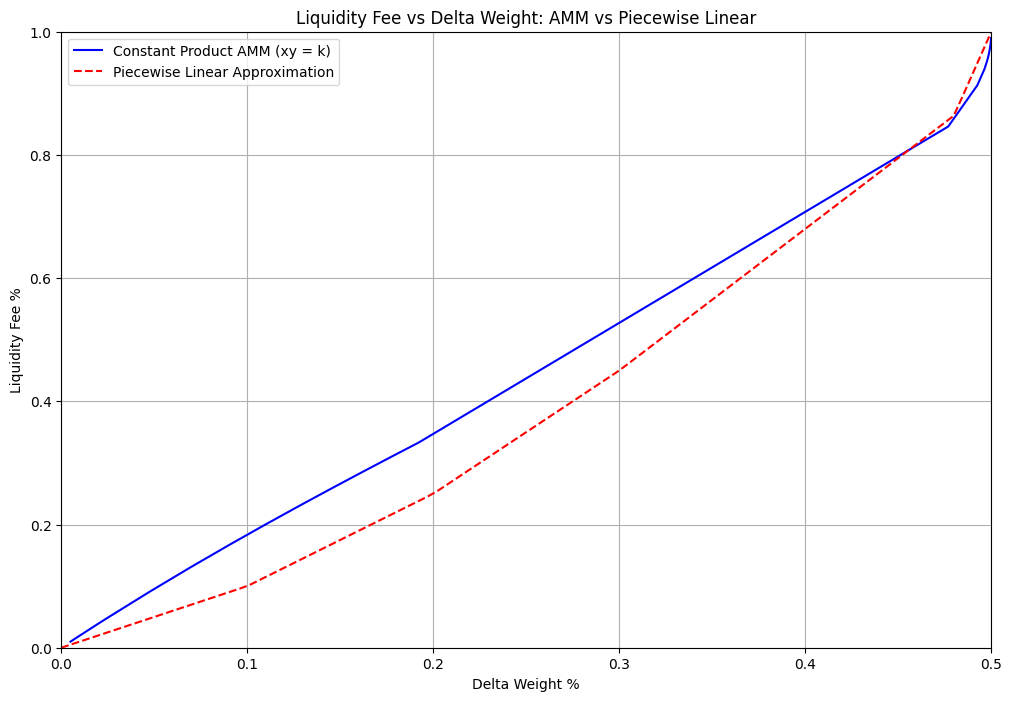


Piecewise Linear Function:
Segment 1: y = 1x + 0 for 0 ≤ x ≤ 0.1:: y_start: 0
Segment 2: y = 1.5x + -0.05000000000000002 for 0.1 ≤ x ≤ 0.2:: y_start: 0.1
Segment 3: y = 2.0x + -0.15000000000000002 for 0.2 ≤ x ≤ 0.3:: y_start: 0.25
Segment 4: y = 2.3x + -0.24 for 0.3 ≤ x ≤ 0.48:: y_start: 0.44999999999999996
Segment 5: y = 6.8x + -2.4 for 0.48 ≤ x ≤ 0.5:: y_start: 0.8639999999999999


In [5]:
# Create a piecewise function
pw = PiecewiseLinear()
    
# Add segments: (start_x, end_x, slope)
#Segment 1: y = 1x + 0           for 0 ≤ x ≤ 0.1    (y_start: 0)
#Segment 2: y = 1.5x - 0.05     for 0.1 ≤ x ≤ 0.2  (y_start: 0.1)
#Segment 3: y = 2.0x - 0.15     for 0.2 ≤ x ≤ 0.3  (y_start: 0.25)
#Segment 4: y = 2.3x - 0.24     for 0.3 ≤ x ≤ 0.48 (y_start: 0.45)
#Segment 5: y = 6.8x - 2.4      for 0.48 ≤ x ≤ 0.5 (y_start: 0.864)
                         
pw.add_segment(0, 0.1, 1)    # slope = 1 from x=0 to x=2
pw.add_segment(0.1, 0.2, 1.5)   # slope = -2 from x=2 to x=4
pw.add_segment(0.2, 0.3, 2.0)  # slope = 0.5 from x=4 to x=6
pw.add_segment(0.3, 0.48, 2.3)  # slope = 0.5 from x=4 to x=6
pw.add_final_segment()
    
# Display the function
pw.display()

# pw.evaluate(0.2)
    
# Test some points
#test_points = [0, 1, 2, 3, 4, 5, 6]
#for x in test_points:
#    print(f"f({x}) = {pw.evaluate(x)}")
pw.compare_amm_and_piecewise()

In [166]:
#0.8639999999999999 + 6.8 * (0.5 - 0.48)
0.864 + 6.8 * (0.5 - 0.48)
0.45 + 2.3 * (0.48 - 0.3)

#pw.compare_stable_and_piecewise()

0.864

In [54]:
PiecewiseLinear.compute_stable_swap(100, 100, 1) # returns delta_y, new_x, new_y

(1.0025503227399497, 101, 98.99744967726005)

In [133]:

# Test it
delta_y, new_x, new_y = PiecewiseLinear.compute_stable_swap(1)
print(f"Delta Y: {delta_y:.6f}, New X: {new_x:.6f}, New Y: {new_y:.6f}")

Delta Y: 0.999801, New X: 101.000000, New Y: 99.000199


In [134]:
# Test it
delta_y, new_x, new_y = PiecewiseLinear.compute_stable_swap(91)
print(f"Delta Y: {delta_y:.6f}, New X: {new_x:.6f}, New Y: {new_y:.6f}")


Delta Y: 87.723457, New X: 191.000000, New Y: 12.276543


In [ ]:
from stable_swap import StableSwap

# Set your reserves and amplification factor
reserve_x = 100  # Reserve of token X
reserve_y = 100  # Reserve of token Y
A = 100  # Amplification factor (typically between 1 and 100)

# Initialize the StableSwap instance with the reserves and amplification factor
pool = StableSwap(reserves=[reserve_x, reserve_y], A=A)

# Define the amount of X you want to swap
amount_in_x = 10  # Example: you want to swap 10 units of X for Y

# Perform the swap (getting the amount of Y you receive)
amount_out_y = pool.get_amount_out(amount_in_x, 0)  # `0` means we want to swap from token X to token Y

# Print the result
print(f"Amount of Y received for {amount_in_x} X: {amount_out_y}")


In [173]:
0.864 + 6.8 * (0.5 - 0.48)

864 + (6800 * (500-480) / 10000)

500 / 1000

0.5

In [124]:
def get_stable_pool(delta_x):
    USER = 'user_test'
    AMPL_COEFF = 100 
    
    amt_x = 100
    decimal_x = 18
    
    amt_y = 100
    decimal_y = 18
    
    x = ERC20("X", "0xA0b", decimal_x)
    x.deposit(None, amt_x)
    
    y = ERC20("Y", "0xf93", decimal_y)
    y.deposit(None, amt_y)
    
    vault = StableswapVault()
    vault.add_token(x)
    vault.add_token(y)
    
    sfactory = StableswapFactory("Pool factory", "0x2")
    exchg_data = StableswapExchangeData(vault = vault, symbol="LP", address="0x011")
    lp = sfactory.deploy(exchg_data)
    lp.join_pool(vault, AMPL_COEFF, USER)
    #lp.summary()

    x_before = lp.get_reserve(x)
    y_before = lp.get_reserve(y)
    
    amt_tkn_in = delta_x
    tkn_in = x
    tkn_out = y
    res = lp.swap(amt_tkn_in, tkn_in, tkn_out, USER)
    delta_y = res['tkn_out_amt']
    new_x = x_before + delta_x
    new_y = y_before - delta_y

    return delta_y, new_x, new_y

In [129]:
get_stable_pool(99)

(92.90189683112165, 199, 7.098103168878353)

Segment 1: y = 0.7x + 0.0 for 0 ≤ x ≤ 0.1
Segment 2: y = 1.2x + -0.05 for 0.1 ≤ x ≤ 0.25
Segment 3: y = 2x + -0.25 for 0.25 ≤ x ≤ 0.35
Segment 4: y = 3x + -0.5999999999999999 for 0.35 ≤ x ≤ 0.46
Segment 5: y = 5.500000000000002x + -1.750000000000001 for 0.46 ≤ x ≤ 0.5


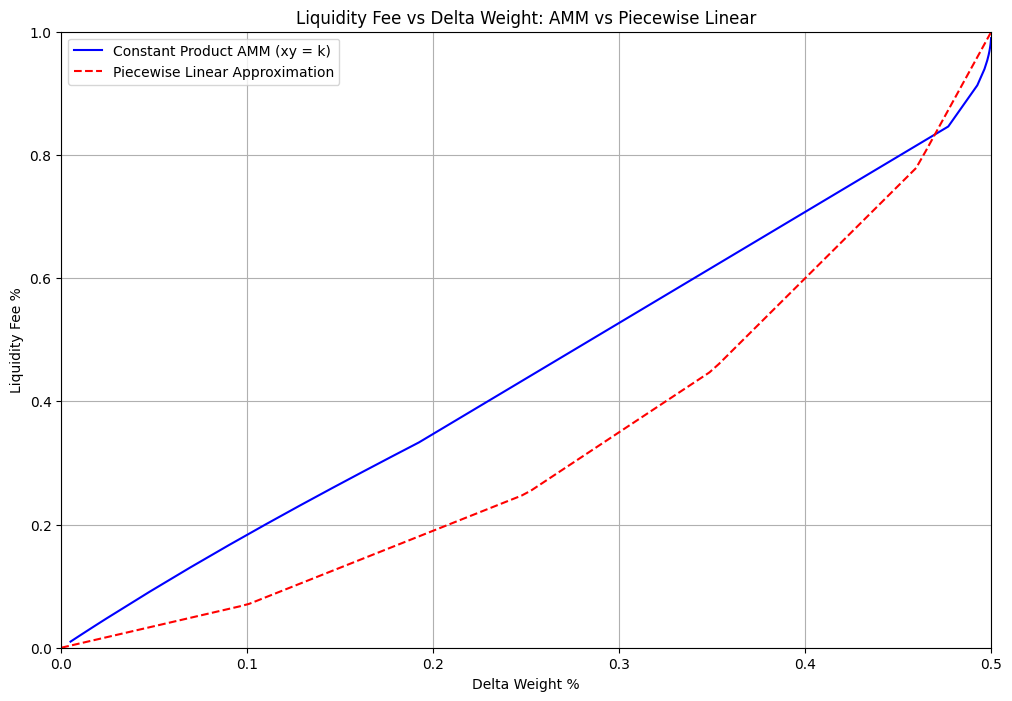


Piecewise Linear Function:
Segment 1: y = 0.7x + 0.0 for 0 ≤ x ≤ 0.1
Segment 2: y = 1.2x + -0.05 for 0.1 ≤ x ≤ 0.25
Segment 3: y = 2x + -0.25 for 0.25 ≤ x ≤ 0.35
Segment 4: y = 3x + -0.5999999999999999 for 0.35 ≤ x ≤ 0.46
Segment 5: y = 5.500000000000002x + -1.750000000000001 for 0.46 ≤ x ≤ 0.5


In [154]:
# Create a piecewise function
pw = PiecewiseLinear()
    
# Add segments: (start_x, end_x, slope)
pw.add_segment(0, 0.1, 0.7)    # slope = 1 from x=0 to x=0.1
pw.add_segment(0.1, 0.25, 1.2)    # slope = 1 from x=0 to x=0.1
pw.add_segment(0.25, 0.35, 2)    # slope = 1 from x=0 to x=0.1
pw.add_segment(0.35, 0.46, 3)    # slope = 1 from x=0 to x=0.1
#pw.add_segment(0.4, 0.46, 3)    # slope = 1 from x=0 to x=0.1
#pw.add_segment(0.4, 0.5, 2.5)  # slope = 0.5 from x=4 to x=6
pw.add_final_segment()
    
# Display the function
pw.display()

# pw.evaluate(0.2)
    
# Test some points
#test_points = [0, 1, 2, 3, 4, 5, 6]
#for x in test_points:
#    print(f"f({x}) = {pw.evaluate(x)}")
pw.compare_amm_and_piecewise()

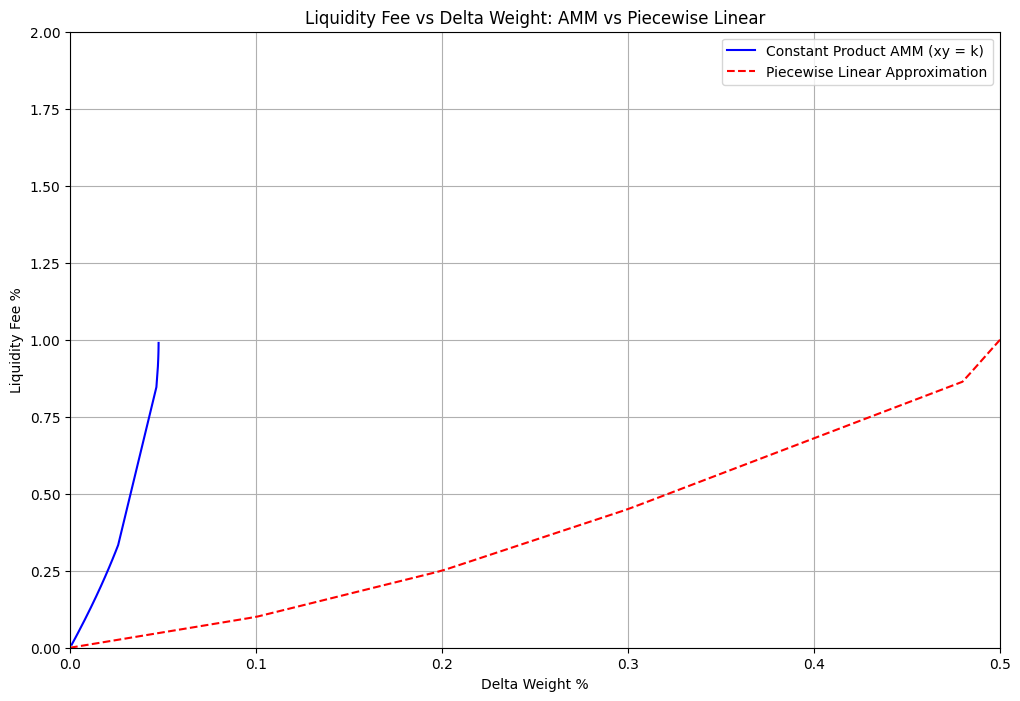


Piecewise Linear Function:
Segment 1: y = 1x + 0 for 0 ≤ x ≤ 0.1:: y_start: 0
Segment 2: y = 1.5x + -0.05000000000000002 for 0.1 ≤ x ≤ 0.2:: y_start: 0.1
Segment 3: y = 2.0x + -0.15000000000000002 for 0.2 ≤ x ≤ 0.3:: y_start: 0.25
Segment 4: y = 2.3x + -0.24 for 0.3 ≤ x ≤ 0.48:: y_start: 0.44999999999999996
Segment 5: y = 6.8x + -2.4 for 0.48 ≤ x ≤ 0.5:: y_start: 0.8639999999999999


In [6]:
pw.compare_amm_and_piecewise_highly_imbalanced()